In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime, timedelta
from scipy.optimize import minimize 

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [57]:
START_DATE = "2019-01-01"
#END_DATE = "2020-11-11"
END_DATE = datetime.today().strftime("%Y-%m-%d")

In [58]:
def stock_price():
    #Creates the dataset containing all stock prices and S&P 500 price "SPY"
    ticker_list = pd.read_csv("invest_list.csv")["0"].to_list() + ['SPY']
    
    # Get all Adjusted Close prices for all the tickers in our list,
    # between START_DATE and END_DATE
    all_data = pdr.get_data_yahoo(ticker_list, start=START_DATE, end=END_DATE)
    stock_raw_data = all_data["Adj Close"]
    
    #Remove rows with null price data
    stock_raw_data.dropna(how="any", axis=0, inplace=True)
    
    # Adding weekday number 
    weekday = []
    for day in stock_raw_data.index:
        weekday.append(day.weekday())
    stock_raw_data["weekday"] = weekday
    
    return stock_raw_data

In [59]:
stock_raw_data = stock_price()

<ipython-input-58-726fe7df4f83>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-58-726fe7df4f83>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [60]:
stock_raw_data.head(20)
#stock_new

Symbols,BE,TWLO,ZM,SLP,DKNG,SPY,weekday
Date,,,,,,,
2019-07-25,10.63,147.759995,97.110001,38.726547,9.80,292.955780,3
2019-07-26,10.65,149.949997,102.199997,38.090866,9.80,294.918549,4
2019-07-29,10.32,141.500000,96.470001,39.660198,9.80,294.381470,0
2019-07-30,10.16,140.000000,95.489998,39.143707,9.80,293.658875,1
2019-07-31,10.45,139.110001,95.510002,38.557693,9.80,290.446136,2
2019-08-01,10.21,137.830002,95.099998,41.467899,9.80,287.916931,3
2019-08-02,10.24,133.699997,93.660004,36.541412,9.80,285.749084,4
2019-08-05,9.62,124.519997,89.690002,35.329651,9.80,277.155701,0
2019-08-06,9.22,125.570000,90.430000,37.256546,9.80,281.042236,1


In [61]:
#Weight Optimization
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(portfolio.mean()*weights)
    vol = np.sqrt(np.dot(weights.T,np.dot(portfolio.cov(),weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])
#minimize negative sharpe ratio
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1
# add constriant:check allocation sums to 1
def check_sum(weights):
    return np.sum(weights) - 1

In [62]:
def Optimization():
# create constraint variable: an equition type of constrant. fun: pass in the function: check_sum
    cons = ({'type':'eq','fun':check_sum})
# create weight boundaries
    bounds = ((0,1),(0,1),(0,1),(0,1),(0,1))
# initial guess to start with
    init_guess = [0.2, 0.2, 0.2, 0.2, 0.2]
    opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    return opt_results

In [63]:
def get_holding(total, weights, i):
    s1_w, s2_w, s3_w, s4_w, s5_w = weights
            
    s1_h = (total * s1_w) / BE_Price
    s2_h = (total * s2_w) / TWLO_Price
    s3_h = (total * s3_w) / ZM_Price
    s4_h = (total * s4_w) / SLP_Price
    s5_h = (total * s5_w) / DKNG_Price
    
    #print(i, stock_new.weekday[i], total * s1_w, total * s2_w, total * s3_w, total * s4_w, total * s5_w )
    return s1_h.round(0), s2_h.round(0), s3_h.round(0), s4_h.round(0), s5_h.round(0)

In [93]:
#Main
stock_new = stock_raw_data.copy()

initial_value = 10000

BE_Weight = []
TWLO_Weight = []
ZM_Weight = []
SLP_Weight = []
DKNG_Weight = []

BE_Holding = []
TWLO_Holding = []
ZM_Holding = []
SLP_Holding = []
DKNG_Holding = []

Portfolio = []
SPY_Bench = []
SPY_Holding = initial_value/stock_new["SPY"][0]
SPY_Holding = SPY_Holding.round(0)

for i in range(stock_new.shape[0]):
#for i in range(20):
    
    BE_Price = stock_new["BE"][i]
    TWLO_Price = stock_new["TWLO"][i]
    ZM_Price = stock_new["ZM"][i]
    SLP_Price = stock_new["SLP"][i]
    DKNG_Price = stock_new["DKNG"][i]
    SPY_Price = stock_new["SPY"][i]
    
    if i == 0:
        #Initial Value
        total = initial_value
    else:
        #Calculate Protofilo Value
        total = BE_Price*s1_h + TWLO_Price*s2_h + ZM_Price*s3_h + SLP_Price*s4_h + DKNG_Price*s5_h
    Portfolio.append(total)
    
    SPY_Bench.append(SPY_Holding*SPY_Price)
    
    #Exeaute Strategy
    # weekday[i] == 1, 1 is for Tuesday
    if stock_new.weekday[i] == 1 or i == 0:
        reg_return = stock_new.iloc[i-20:i,:5]
        portfolio = np.log(reg_return/reg_return.shift(1))
        opt_results = Optimization()
        s1_h, s2_h, s3_h, s4_h, s5_h = get_holding(total, opt_results.x, i)
    
    BE_Weight.append(opt_results.x[0].round(2))
    TWLO_Weight.append(opt_results.x[1].round(2))
    ZM_Weight.append(opt_results.x[2].round(2))
    SLP_Weight.append(opt_results.x[3].round(2))
    DKNG_Weight.append(opt_results.x[4].round(2))

    BE_Holding.append(s1_h)
    TWLO_Holding.append(s2_h)
    ZM_Holding.append(s3_h)
    SLP_Holding.append(s4_h)
    DKNG_Holding.append(s5_h)

stock_new["BE_Weight"] = BE_Weight
stock_new["TWLO_Weight"] = TWLO_Weight
stock_new["ZM_Weight"] = ZM_Weight
stock_new["SLP_Weight"] = SLP_Weight
stock_new["DKNG_Weight"] = DKNG_Weight

stock_new["BE_Holding"] = BE_Holding
stock_new["TWLO_Holding"] = TWLO_Holding
stock_new["ZM_Holding"] = ZM_Holding
stock_new["SLP_Holding"] = SLP_Holding
stock_new["DKNG_Holding"] = DKNG_Holding

stock_new["Portfolio"] = Portfolio
stock_new["SPY_Bench"] = SPY_Bench


F:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning:

Mean of empty slice.

F:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:162: RuntimeWarning:

invalid value encountered in true_divide

F:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:8276: RuntimeWarning:

Degrees of freedom <= 0 for slice

F:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning:

divide by zero encountered in true_divide

F:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning:

invalid value encountered in multiply



In [94]:
stock_new.tail(20)
#stock_new.head(40)

Symbols,BE,TWLO,ZM,SLP,DKNG,SPY,weekday,BE_Weight,TWLO_Weight,ZM_Weight,SLP_Weight,DKNG_Weight,BE_Holding,TWLO_Holding,ZM_Holding,SLP_Holding,DKNG_Holding,Portfolio,SPY_Bench
Date,,,,,,,,,,,,,,,,,,,
2020-10-22,16.610001,294.029999,520.539978,69.950005,43.000000,344.609985,3,0.04,0.50,0.24,0.22,0.0,119.0,93.0,26.0,183.0,0.0,55656.270226,11716.739502
2020-10-23,16.430000,306.100006,511.519989,70.059998,42.740002,345.779999,4,0.04,0.50,0.24,0.22,0.0,119.0,93.0,26.0,183.0,0.0,56542.969872,11756.519958
2020-10-26,15.670000,300.619995,517.789978,69.110001,39.689999,339.390015,0,0.04,0.50,0.24,0.22,0.0,119.0,93.0,26.0,183.0,0.0,55932.059095,11539.260498
2020-10-27,15.420000,286.290009,538.989990,68.190002,38.700001,338.220001,1,0.00,0.49,0.51,0.00,0.0,0.0,93.0,52.0,0.0,0.0,54952.460997,11499.480042
2020-10-28,14.600000,296.959991,516.010010,67.820000,38.150002,326.660004,2,0.00,0.49,0.51,0.00,0.0,0.0,93.0,52.0,0.0,0.0,54449.799713,11106.440125
2020-10-29,14.720000,288.579987,489.679993,66.650002,37.369999,329.980011,3,0.00,0.49,0.51,0.00,0.0,0.0,93.0,52.0,0.0,0.0,52301.298370,11219.320374
2020-10-30,12.640000,278.970001,460.910004,64.820000,35.400002,326.540009,4,0.00,0.49,0.51,0.00,0.0,0.0,93.0,52.0,0.0,0.0,49911.530304,11102.360291
2020-11-02,12.990000,273.380005,453.000000,65.300003,35.720001,330.200012,0,0.00,0.49,0.51,0.00,0.0,0.0,93.0,52.0,0.0,0.0,48980.340454,11226.800415
2020-11-03,14.520000,280.369995,451.510010,66.769997,37.470001,336.029999,1,0.00,0.00,1.00,0.00,0.0,0.0,0.0,110.0,0.0,0.0,49552.930054,11425.019958


<AxesSubplot:xlabel='Date'>

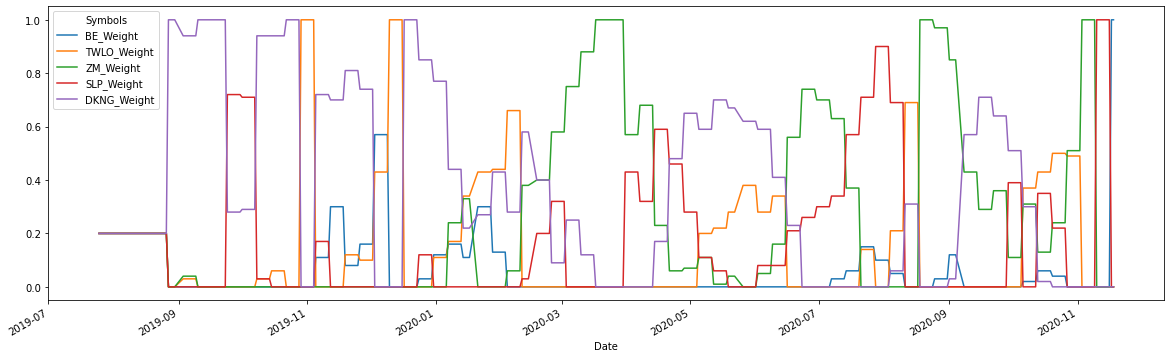

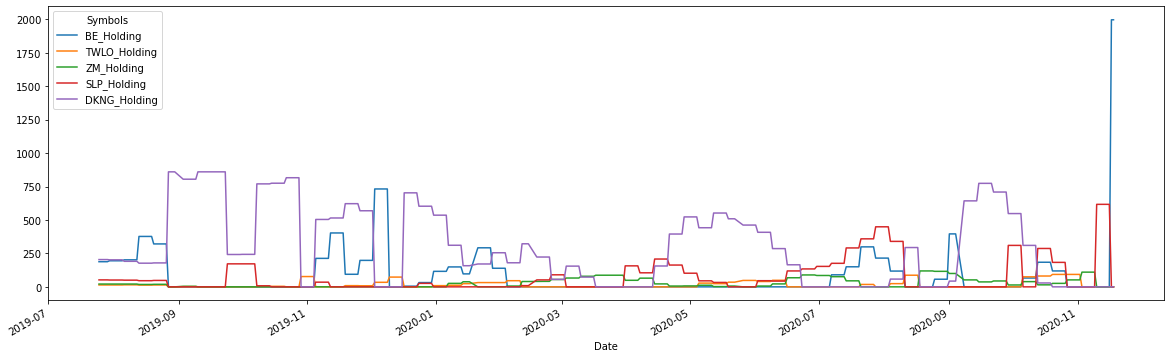

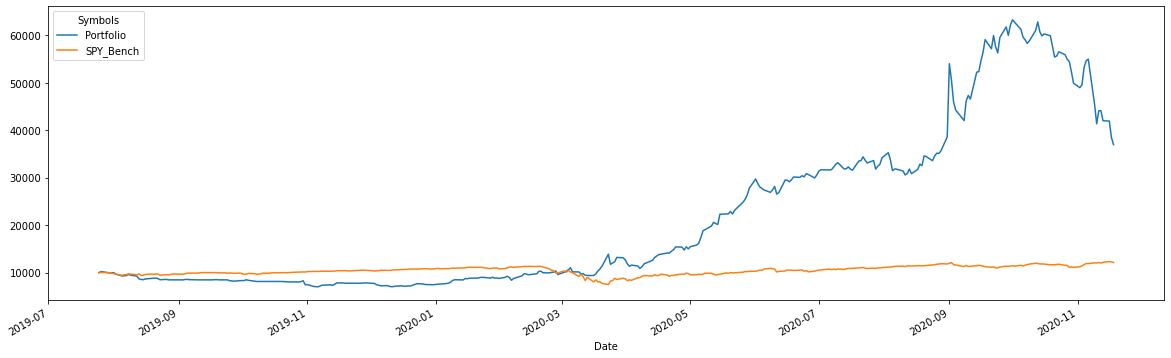

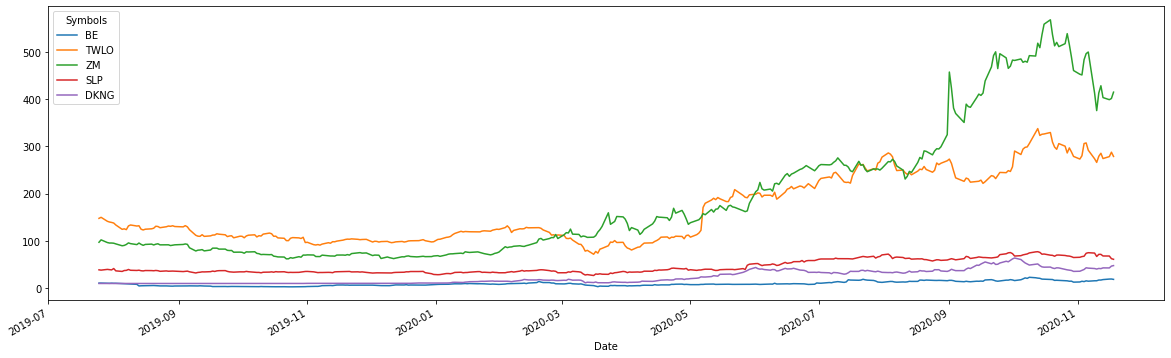

In [99]:
%matplotlib inline
#stock_new.plot()
stock_new[["BE_Weight","TWLO_Weight", "ZM_Weight", "SLP_Weight", "DKNG_Weight"]].plot(figsize=(20, 6))
stock_new[["BE_Holding","TWLO_Holding", "ZM_Holding", "SLP_Holding", "DKNG_Holding"]].plot(figsize=(20, 6))
stock_new[["Portfolio", "SPY_Bench"]].plot(figsize=(20, 6))
stock_new[["BE","TWLO", "ZM", "SLP", "DKNG"]].plot(figsize=(20, 6))

In [98]:
%%HTML
<div class='tableauPlaceholder' id='viz1605760565612' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ba&#47;Backtest_16057605330820&#47;Story1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Backtest_16057605330820&#47;Story1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ba&#47;Backtest_16057605330820&#47;Story1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1605760565612');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1016px';vizElement.style.height='991px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [96]:
stock_new.to_csv("Portfolio_Backtest_Result.csv")